In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sampledata = pd.read_table("SRR1068687.tsv")

In [4]:
sampledata.head(2)

target_id  length  eff_length  \
0  ENST00000456328.2|ENSG00000223972.5|OTTHUMG000...    1657    1451.470   
1  ENST00000450305.2|ENSG00000223972.5|OTTHUMG000...     632     426.565   

   est_counts       tpm  
0     15.6008  0.462275  
1      0.0000  0.000000

In [5]:
protein_coding = sampledata[sampledata.target_id.str.contains("protein_coding")]

In [6]:
len(protein_coding)

79795

In [7]:
def get_genename(row):
    target_id = list(row)[0]
    genename = target_id.split("|")[1].split(".")[0]
    return genename

In [8]:
gene = protein_coding.apply(get_genename,axis=1)

In [9]:
len(gene)

79795

In [10]:
protein_coding = pd.concat([protein_coding,gene],axis=1)

In [11]:
protein_coding.columns = list(protein_coding.columns[:-1])+["gene"]

In [12]:
protein_coding.head(2)

target_id  length  eff_length  \
11  ENST00000335137.3|ENSG00000186092.4|OTTHUMG000...     918      712.47   
28  ENST00000624431.1|ENSG00000279928.1|-|-|FO5387...     718      512.47   

    est_counts       tpm             gene  
11      0.0000  0.000000  ENSG00000186092  
28     11.7984  0.990181  ENSG00000279928

In [13]:
longest = []
for name,df in protein_coding.groupby("gene"):
    if len(df)>1:
        longest.append( list(df[df.length==max(df.length)].gene.index)[0] )
    else:
        longest.append( list(df.gene.index)[0] )

In [14]:
len(longest)

19645

In [15]:
len(protein_coding)

79795

In [16]:
longest[:10]

[194908, 194906, 183688, 12986, 12967, 3156, 13988, 68176, 65059, 64243]

In [17]:
longest.sort()

In [18]:
longest[:10]

[11, 28, 30, 61, 88, 149, 163, 168, 176, 181]

In [19]:
genenames = [x.split("|")[5] for x in list(sampledata.target_id[longest]) ]

In [20]:
#gtex = "GTEX_3282_sample_phenotype.txt"

In [21]:
#big_matrix = pd.DataFrame()
#
#with open (gtex) as samples:
#    for sample in samples:
#        individual, accession, tissue = sample.strip().split('\t')[:3]
#        current_tsv = accession+".tsv"
#        #current_tsv = "SRR1068687.tsv"
#        current_dataframe = pd.read_csv(current_tsv,sep="\t")
#        current_dataframe = current_dataframe.loc[longest,:]
#        new_tpm = (current_dataframe.est_counts*10**6)/(current_dataframe.eff_length*sum(current_dataframe.est_counts/current_dataframe.eff_length))
#        out = pd.Series([individual,tissue]).append(new_tpm)
#        big_matrix = big_matrix.append(out,ignore_index=True)
#
#big_matrix.to_csv("longest_protein_coding_genes_recalculated_tpm_matrix.txt",sep="\t",header=False,index=False)

In [22]:
data = pd.read_table("longest_protein_coding_genes_recalculated_tpm_matrix.txt",header=None)

In [23]:
data.columns = ["sid","tissue"]+genenames

In [24]:
mitochondrial = data.loc[:,["sid","tissue"]+[gene for gene in list(data.columns) if gene.startswith("MT-")]]

In [25]:
sample_data = pd.read_csv("SRR1068687.tsv",sep="\t")

# HK genes column names
HK_rows = "housekeeping_genes_rownumber_id.txt"
rowIdHKGenes = [int(i.strip().split('\t')[0])-2 for i in list(open(HK_rows))]
HK_names_tmp = sample_data.target_id[rowIdHKGenes]
HK_names = [name.split("|")[5] for name in HK_names_tmp.tolist()]

In [26]:
housekeeping = data.loc[:,["sid","tissue"]+HK_names]

In [27]:
def getLog(x):
    return np.log10(x+1)

In [28]:
logHK_df = housekeeping.iloc[:,2:15].apply(getLog)
logHK_df.columns = HK_names

logHK_df = pd.concat([housekeeping.iloc[:,0:2],logHK_df],axis=1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fffb44c3210>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fffb3f4ac10>]], dtype=object)

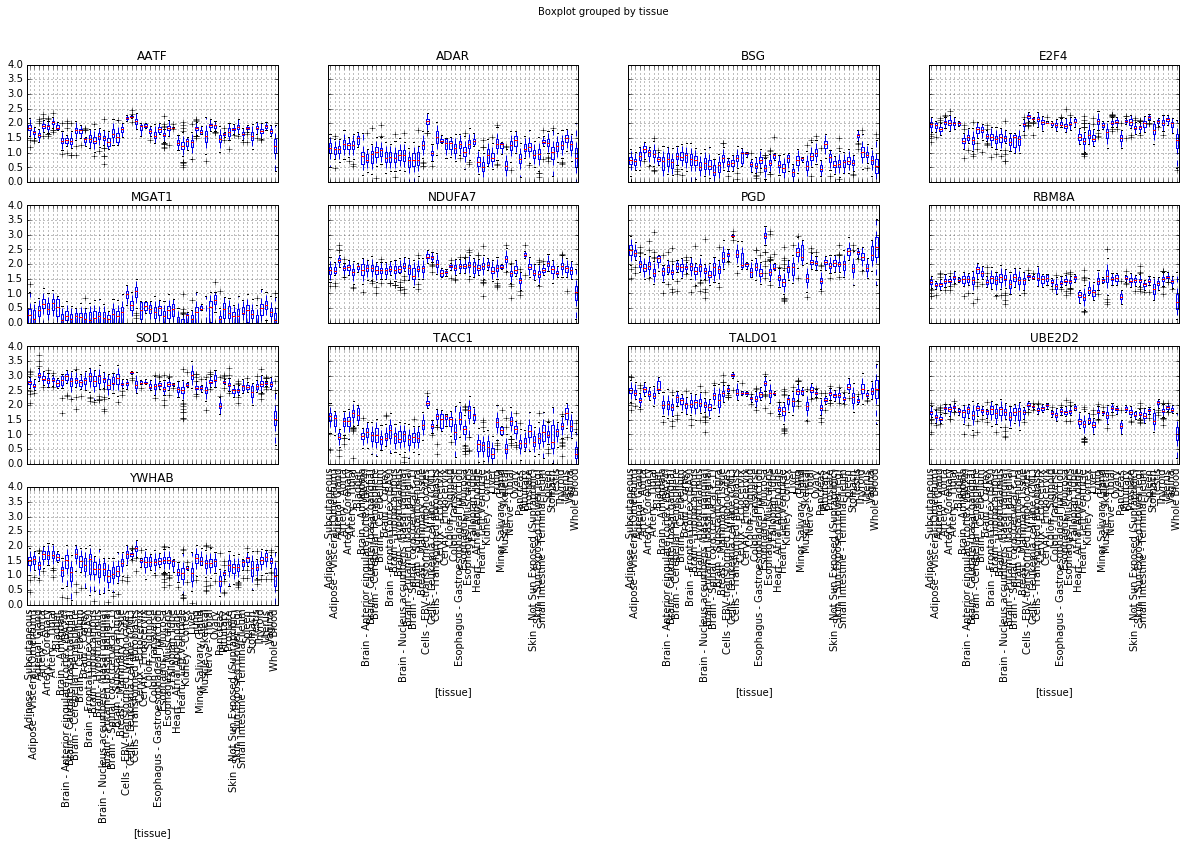

In [29]:
% matplotlib inline 
plt.rcParams['figure.figsize'] = (20.0, 10.0)


logHK_df.boxplot(by=["tissue"],rot=90)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fffaabbbc10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fffaa792dd0>]], dtype=object)

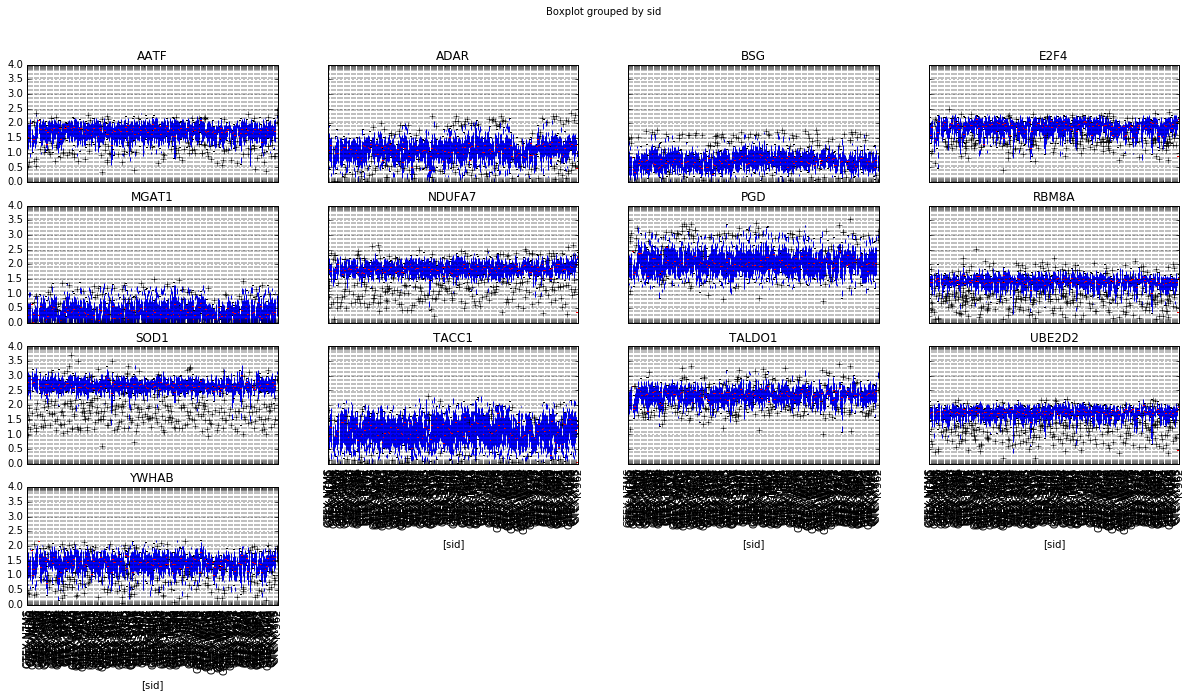

In [30]:
% matplotlib inline 
plt.rcParams['figure.figsize'] = (20.0, 10.0)


logHK_df.boxplot(by=["sid"],rot=90)

In [31]:
logMT = mitochondrial.iloc[:,2:15].apply(getLog)
logMT.columns = list(mitochondrial.columns[2:])

logMT = pd.concat([mitochondrial.iloc[:,0:2],logMT],axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fff62435ad0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fff608d7dd0>]], dtype=object)

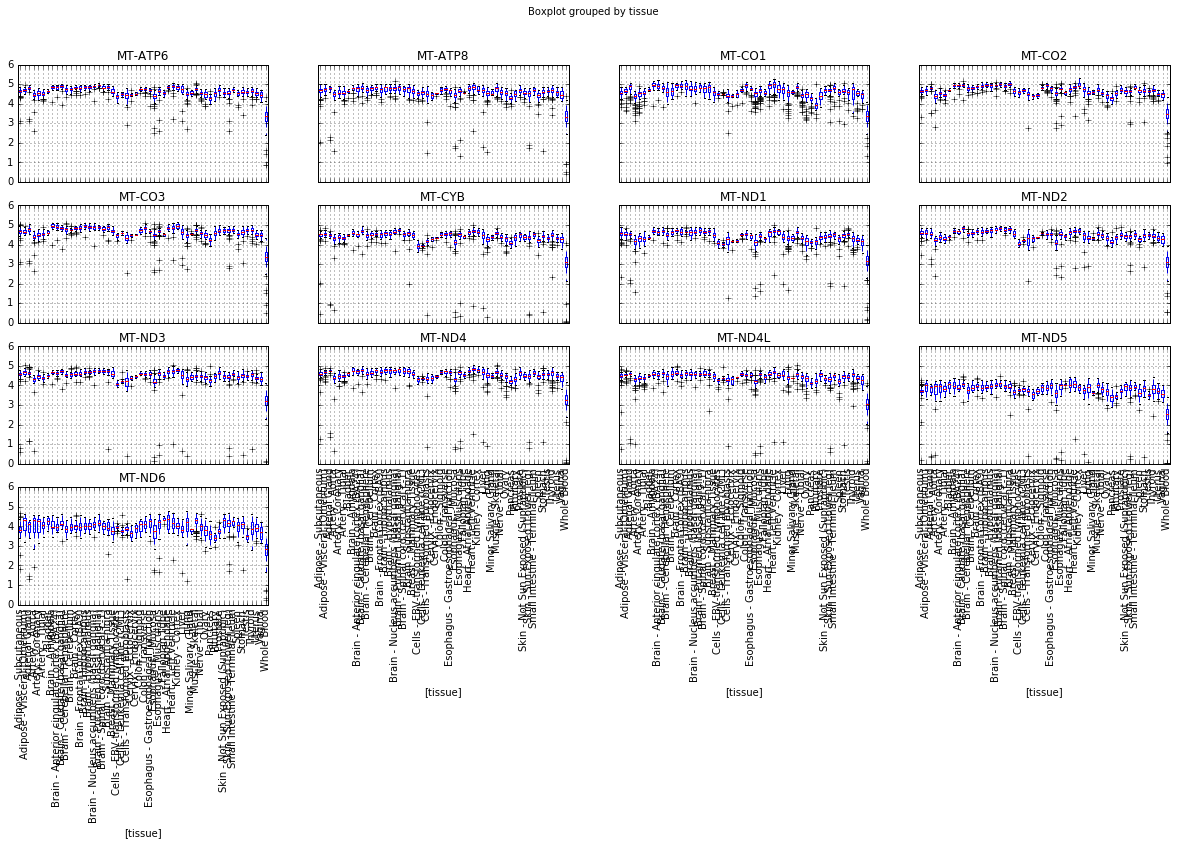

In [32]:
% matplotlib inline 
plt.rcParams['figure.figsize'] = (20.0, 10.0)


logMT.boxplot(by=["tissue"],rot=90)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fff5aac3c50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fff59c69b10>]], dtype=object)

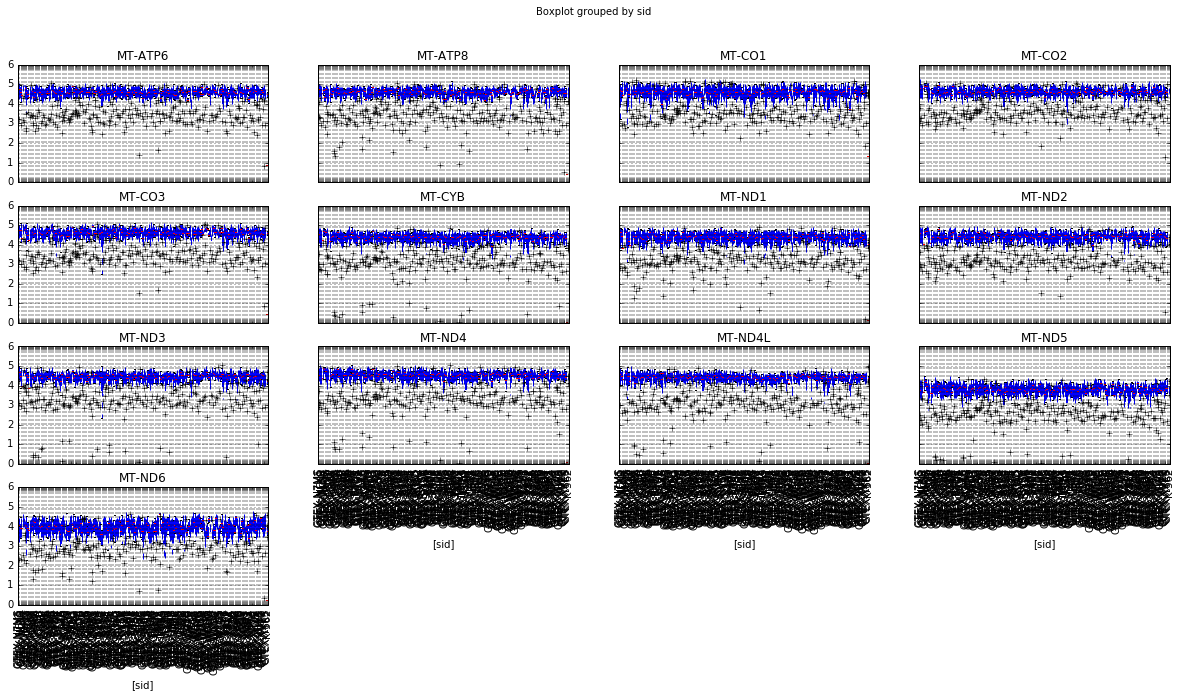

In [33]:
% matplotlib inline 
plt.rcParams['figure.figsize'] = (20.0, 10.0)


logMT.boxplot(by=["sid"],rot=90)

In [34]:
def divide(x):
    return x[1:]/x[0]

In [35]:
norm =  pd.concat( [logHK_df["NDUFA7"],logMT.iloc[:,2:]],axis=1 ).apply(divide,axis=1)
norm = pd.concat([mitochondrial.iloc[:,0:2], norm],axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fff3a53ccd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fff3a7cc3d0>]], dtype=object)

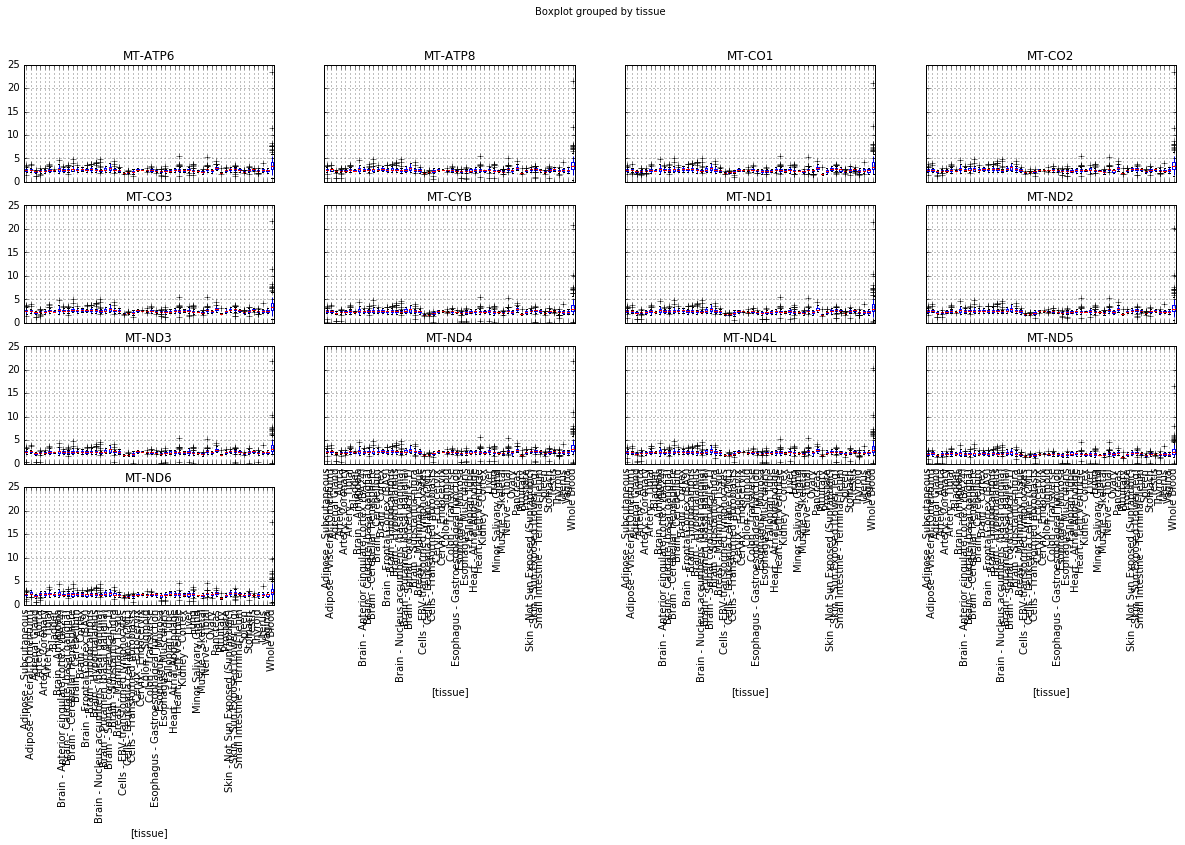

In [36]:
% matplotlib inline 
plt.rcParams['figure.figsize'] = (20.0, 10.0)


norm.boxplot(by=["tissue"],rot=90)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fff3a574f10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fff34c5b050>]], dtype=object)

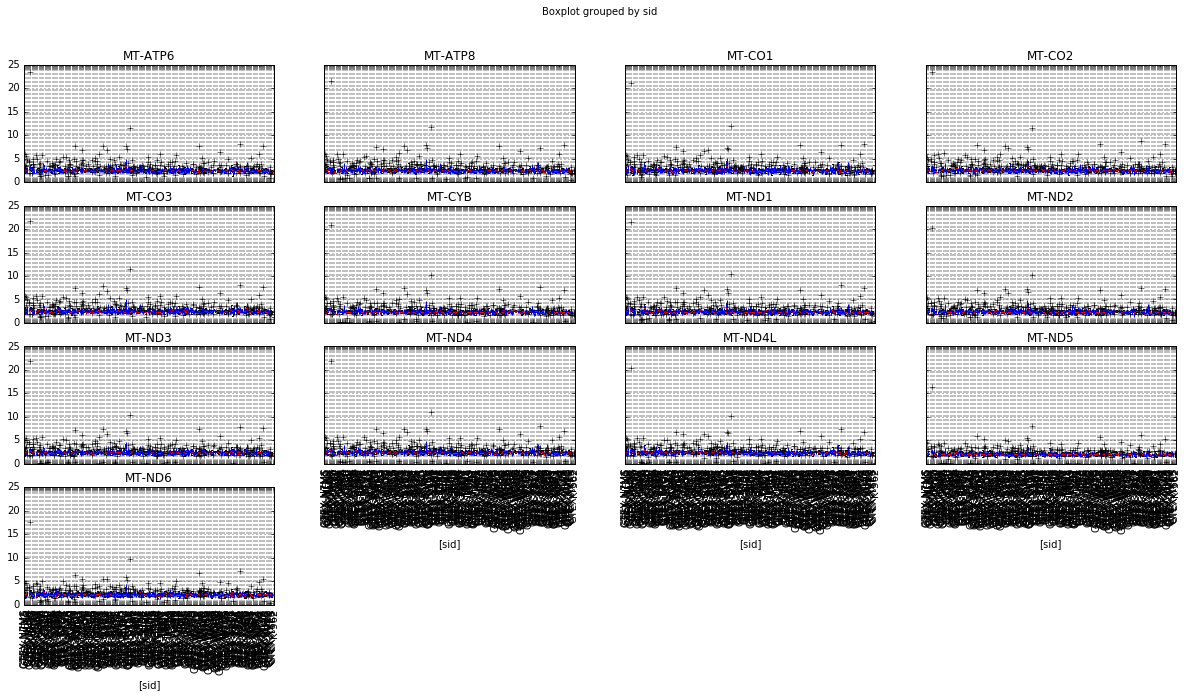

In [37]:
% matplotlib inline 
plt.rcParams['figure.figsize'] = (20.0, 10.0)


norm.boxplot(by=["sid"],rot=90)

In [38]:
!ls *txt

adjusted_matrix_log_tpm.txt
all_data_tpm_matrix.txt
GTEX_3282_sample_phenotype.txt
GTEx_sample_accession.txt
housekeeping_genes_annotation.txt
housekeeping_genes_ensembl_id.txt
housekeeping_genes_rownumber_id.txt
housekeeping_genes_tpm_matrix_3282.txt
housekeeping_genes.txt
longest_protein_coding_genes_recalculated_tpm_matrix.txt
matrix_gene_column_names.txt
mitonuclear_genes_rowNumber_id.txt
mitonuc_mito_numt_tpm_matrix_3282.txt
temp_HK_list.txt


In [39]:
phenotypes = pd.read_table("GTEX_3282_sample_phenotype.txt",header=None)
phenotypes.columns = ["sid","sra","tissue","sid2","collection","gender","age","race","ethnicity","BMI","COD","TOD"]

In [40]:
phenotypes.head()

sid        sra                           tissue       sid2  \
0  GTEX-PW2O  SRR598484                             Lung  GTEX-PW2O   
1  GTEX-NPJ8  SRR598124                 Brain - Amygdala  GTEX-NPJ8   
2  GTEX-N7MT  SRR599192  Brain - Caudate (basal ganglia)  GTEX-N7MT   
3  GTEX-OHPK  SRR601925                             Lung  GTEX-OHPK   
4  GTEX-Q2AG  SRR601068   Skin - Sun Exposed (Lower leg)  GTEX-Q2AG   

          collection  gender  age  race  ethnicity    BMI  \
0  Organ Donor (OPO)       1   23     3          0  29.56   
1         Postmortem       1   40     3         98  27.89   
2         Postmortem       2   68     3         98  24.41   
3  Organ Donor (OPO)       2   51     2          0  30.11   
4         Postmortem       2   42     3         98  32.28   

                    COD       TOD  
0          Blunt Injury  Accident  
1  Hepatorenal Syndrome   Natural  
2      Liver Transplant   Natural  
3                   ICH   Natural  
4    heart disease (MI)   Natural

In [42]:
def save_df(df,name):
    df.to_csv(name, sep="\t",header=True, index=False)
    return

In [43]:
save_df(logHK_df,"logHK.df.txt")

In [44]:
save_df(logMT, "logMT.df.txt")

In [45]:
!ls *df*

logHK.df.txt  logMT.df.txt


In [46]:
! head logMT.df.txt|cut -f -5

sid	tissue	MT-ND1	MT-ND2	MT-CO1
GTEX-PW2O	Lung	4.42392126017	4.30856056314	4.8181451792
GTEX-NPJ8	Brain - Amygdala	4.77288245169	4.7497377016	5.04798750793
GTEX-N7MT	Brain - Caudate (basal ganglia)	4.7471488741	4.78788301102	4.78807587418
GTEX-OHPK	Lung	4.46066276938	4.46588850535	4.72647283221
GTEX-Q2AG	Skin - Sun Exposed (Lower leg)	4.46076448662	4.40612204557	4.69248998258
GTEX-Q2AG	Brain - Spinal cord (cervical c-1)	4.85549298078	4.9039257026	4.93896643926
GTEX-OXRL	Lung	4.42466777669	4.37510265007	4.63380356336
GTEX-OXRK	Lung	4.13843564655	4.09036605151	4.63594615229
GTEX-Q2AG	Brain - Amygdala	4.72980621814	4.70345000699	4.78462717473


In [47]:
logMT.head()

sid                           tissue    MT-ND1    MT-ND2    MT-CO1  \
0  GTEX-PW2O                             Lung  4.423921  4.308561  4.818145   
1  GTEX-NPJ8                 Brain - Amygdala  4.772882  4.749738  5.047988   
2  GTEX-N7MT  Brain - Caudate (basal ganglia)  4.747149  4.787883  4.788076   
3  GTEX-OHPK                             Lung  4.460663  4.465889  4.726473   
4  GTEX-Q2AG   Skin - Sun Exposed (Lower leg)  4.460764  4.406122  4.692490   

     MT-CO2   MT-ATP8   MT-ATP6    MT-CO3    MT-ND3   MT-ND4L    MT-ND4  \
0  4.692092  4.582385  4.564580  4.430688  4.217466  4.572123  4.663234   
1  4.906551  4.791862  4.907215  4.950292  4.643603  4.732201  4.891920   
2  4.924960  4.761292  4.864354  4.753736  4.612740  4.639466  4.795745   
3  4.749920  4.774747  4.551292  4.681787  4.254468  4.382586  4.680219   
4  4.569619  4.611384  4.547828  4.642974  4.347738  4.367126  4.472411   

     MT-ND5    MT-ND6    MT-CYB  
0  3.935056  4.083345  4.286383  
1  4.213631  4.309431  4.731868  
2  4.069074  4.100998  4.688017  
3  4.239344  4.546107  4.499779  
4  3.731026  3.968101  4.375941

In [75]:
len(list(logMT.tissue.drop_duplicates()))

54

/home/boris/bin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


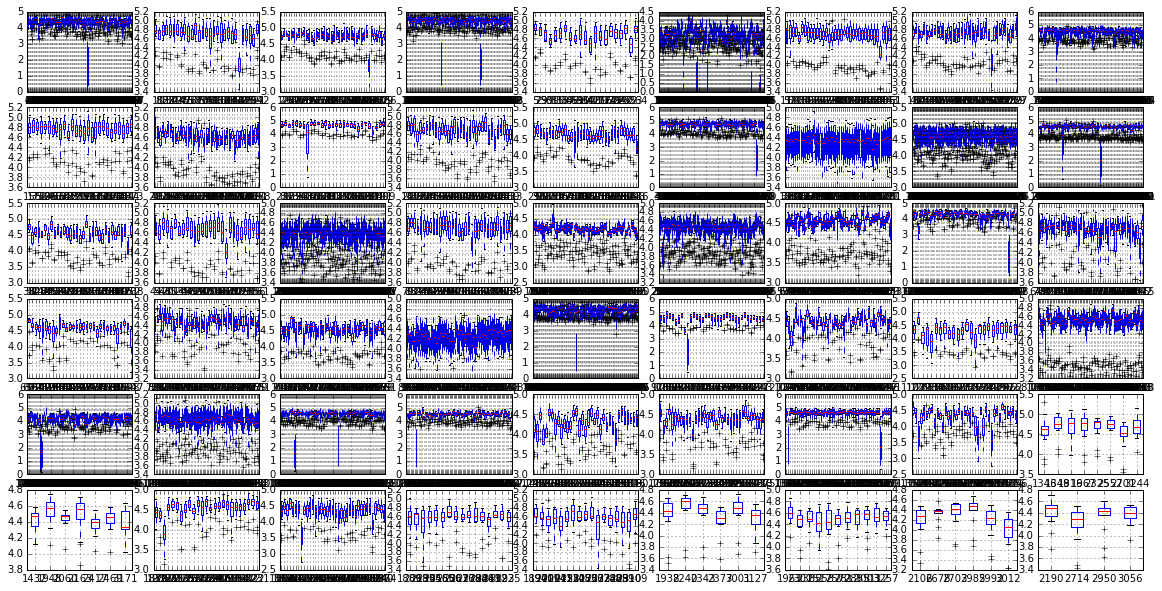

In [80]:
% matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

n=0
for tissue in list(logMT.tissue.drop_duplicates()):
    n+=1
    current_df = logMT.loc[logMT.tissue==tissue, list(logMT.columns[2:])].transpose()
    plt.subplot(6,9,n)
    current_df.boxplot()
    break

/home/boris/bin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


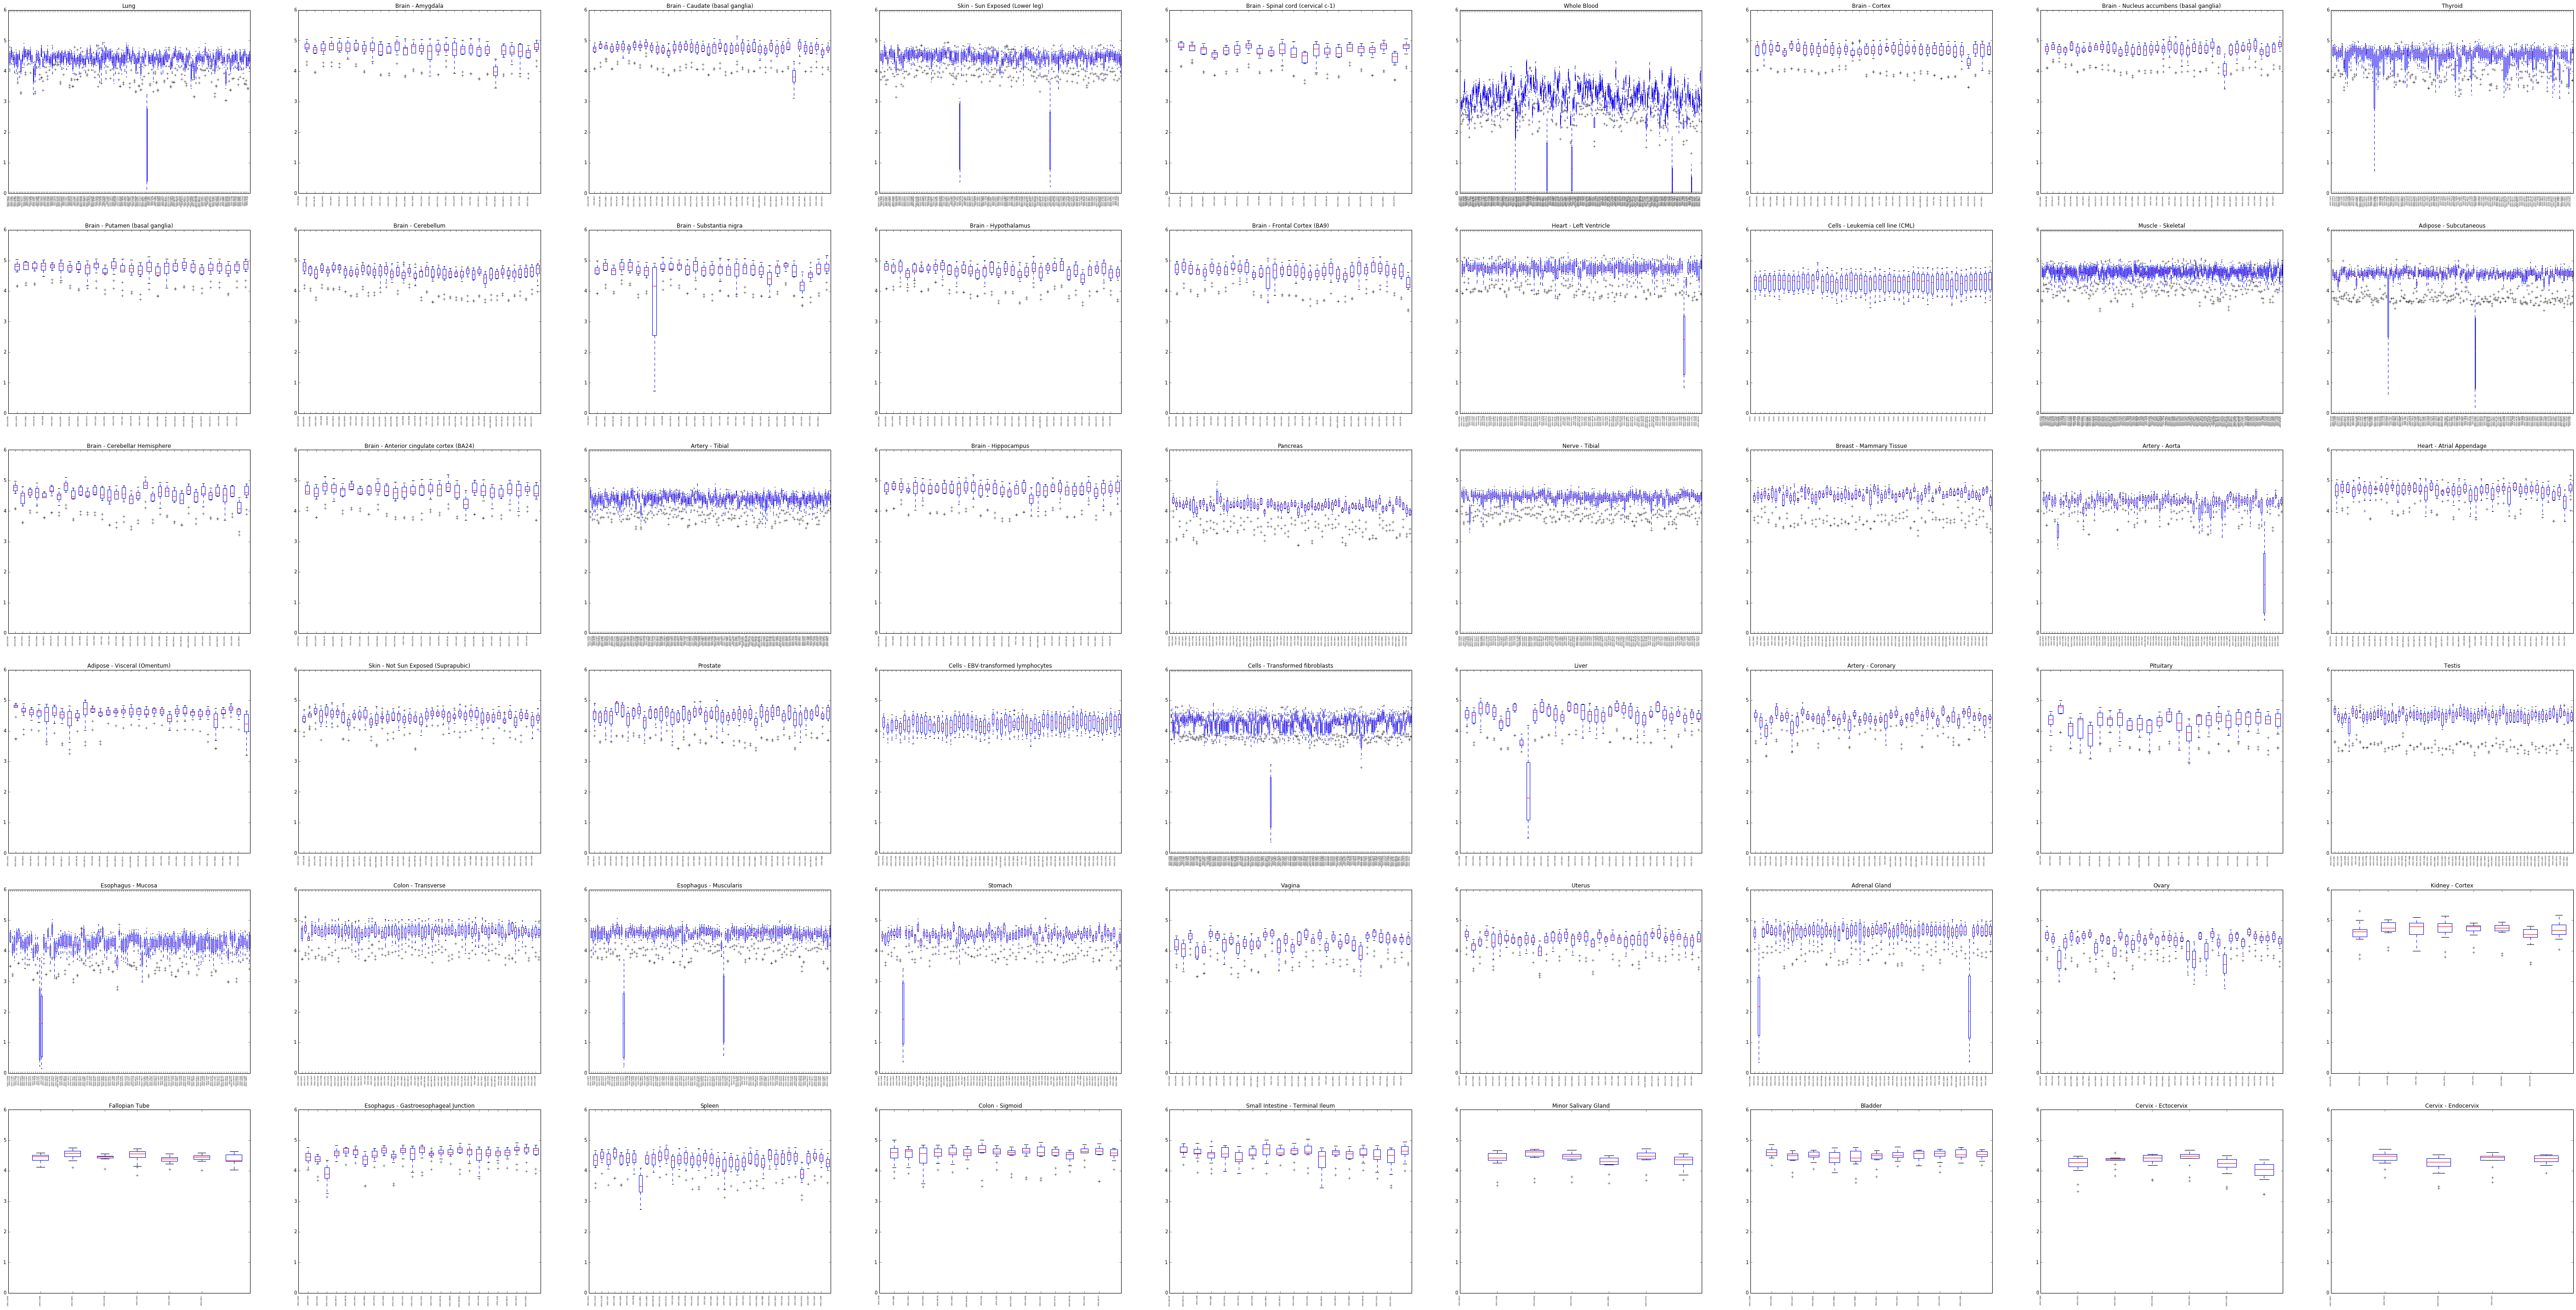

In [105]:
% matplotlib inline
plt.rcParams['figure.figsize'] = (100.0, 50.0)

n=0
for tissue in list(logMT.tissue.drop_duplicates()):
    n+=1
    current_df = logMT.loc[logMT.tissue==tissue, list(logMT.columns[2:])].transpose()
    labels_tmp = list(current_df.columns)
    labels = list(logMT.sid[labels_tmp])
    plt.subplot(6,9,n)
    plt.title(tissue)
    plt.ylim([0,6])
    
    current_df.boxplot(grid=False)
    plt.xticks(range(len(current_df.columns)), labels, rotation='vertical',fontsize=4)


In [97]:
len(current_df.columns)

153

In [112]:
nuclear = data.loc[:, [gene for gene in list(data.columns) if not gene.startswith("MT-")]]

In [113]:
nuclear.head()

sid                           tissue  OR4F5  FO538757.3  FO538757.2  \
0  GTEX-PW2O                             Lung      0    0.116555   99.117747   
1  GTEX-NPJ8                 Brain - Amygdala      0    0.059364   19.582183   
2  GTEX-N7MT  Brain - Caudate (basal ganglia)      0    0.135102   38.896319   
3  GTEX-OHPK                             Lung      0    1.020299   56.313625   
4  GTEX-Q2AG   Skin - Sun Exposed (Lower leg)      0    0.576654   94.793049   

     OR4F29    OR4F16    SAMD11       NOC2L     KLHL17    ...     BPY2C  \
0  0.181535  0.181535  2.360295   65.956844  13.385877    ...         0   
1  0.000000  0.000000  0.152406   16.566206   3.782014    ...         0   
2  0.313385  0.313385  0.625531   37.612138   3.924874    ...         0   
3  0.000000  0.000000  0.000000   72.278591  10.168256    ...         0   
4  0.000000  0.000000  0.642068  103.963452  16.340724    ...         0   

   AC006386.1  AC006328.4  CDY1     SPRY3     SPRY3      VAMP7      VAMP7  \
0    0.750143           0     0  1.183374  1.183374  13.589026  13.589026   
1    0.475000           0     0  0.457995  0.457995   6.250444   6.250444   
2    0.686609           0     0  0.647491  0.647491  10.244630  10.244630   
3    1.763171           0     0  1.026953  1.026953   9.520767   9.520767   
4   15.624540           0     0  0.501918  0.501918  10.907410  10.907410   

       IL9R      IL9R  
0  0.516453  0.516453  
1  0.027100  0.027100  
2  0.104739  0.104739  
3  0.736881  0.736881  
4  0.336077  0.336077  

[5 rows x 19796 columns]

In [114]:
logNUC = nuclear.iloc[:,2:].apply(getLog)
logNUC.columns = list(nuclear.columns[2:])

logNUC = pd.concat([nuclear.iloc[:,0:2],logNUC],axis=1)

In [115]:
save_df(logNUC, "logNUC.df.txt")

/home/boris/bin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


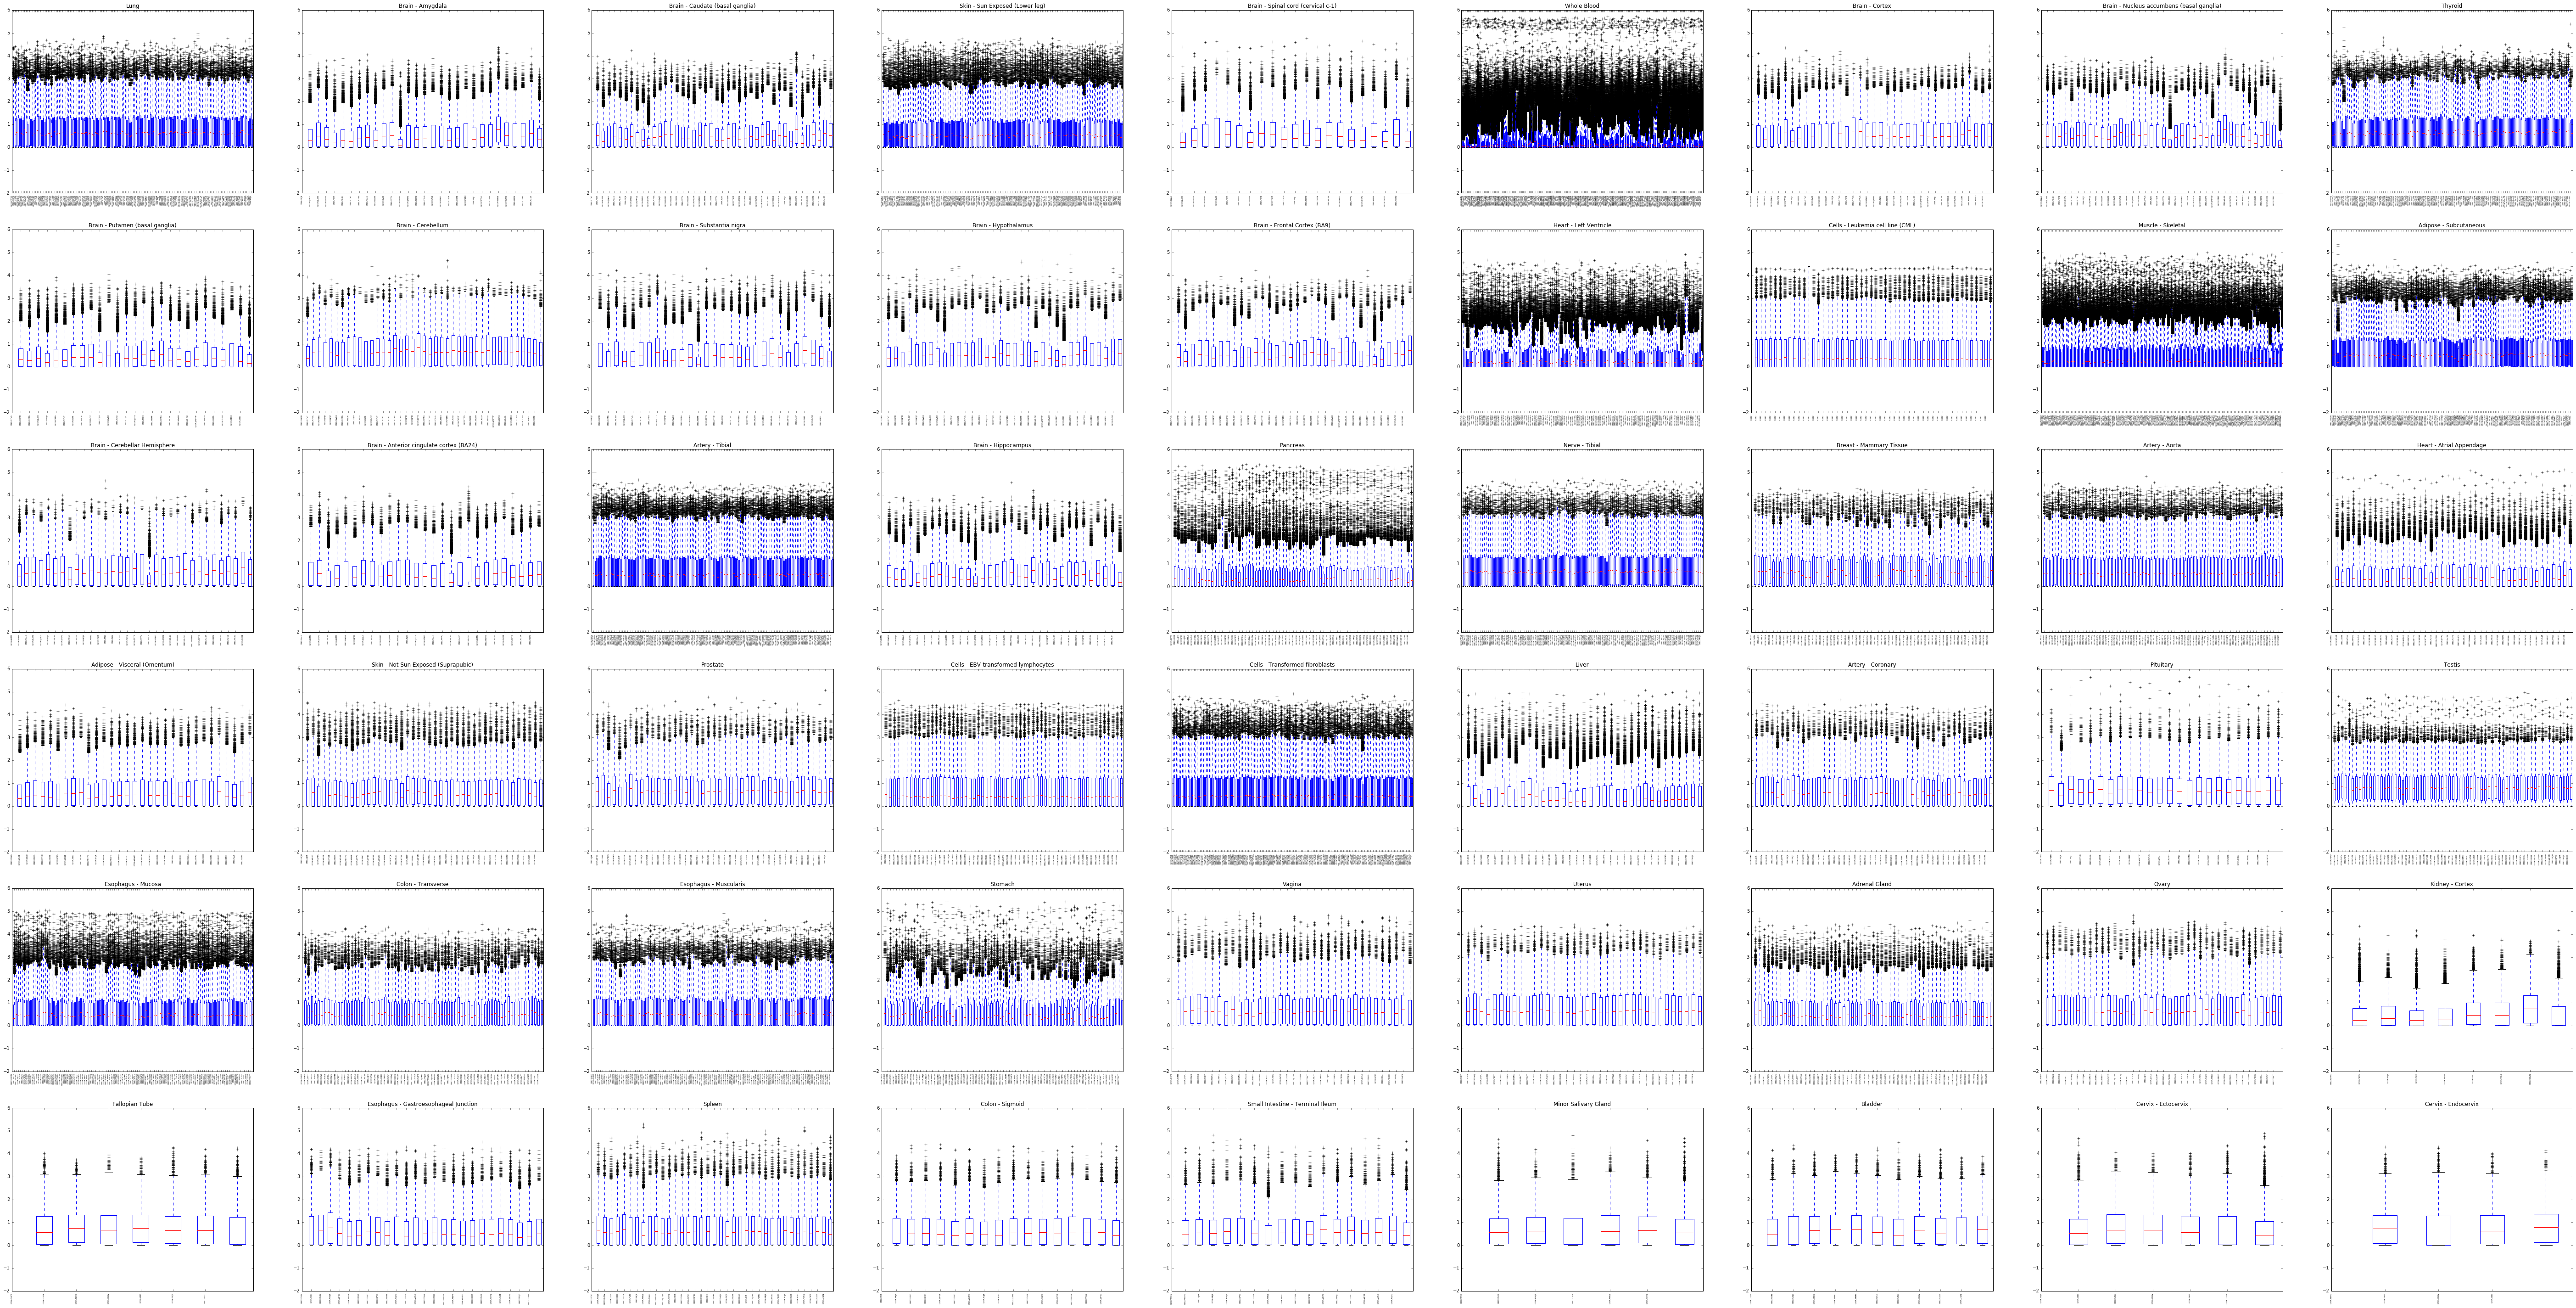

In [117]:
% matplotlib inline
plt.rcParams['figure.figsize'] = (100.0, 50.0)

n=0
for tissue in list(logNUC.tissue.drop_duplicates()):
    n+=1
    current_df = logNUC.loc[logNUC.tissue==tissue, list(logNUC.columns[2:])].transpose()
    labels_tmp = list(current_df.columns)
    labels = list(logNUC.sid[labels_tmp])
    plt.subplot(6,9,n)
    plt.title(tissue)
    plt.ylim([-2,6])
    
    current_df.boxplot(grid=False)
    plt.xticks(range(len(current_df.columns)), labels, rotation='vertical',fontsize=4)

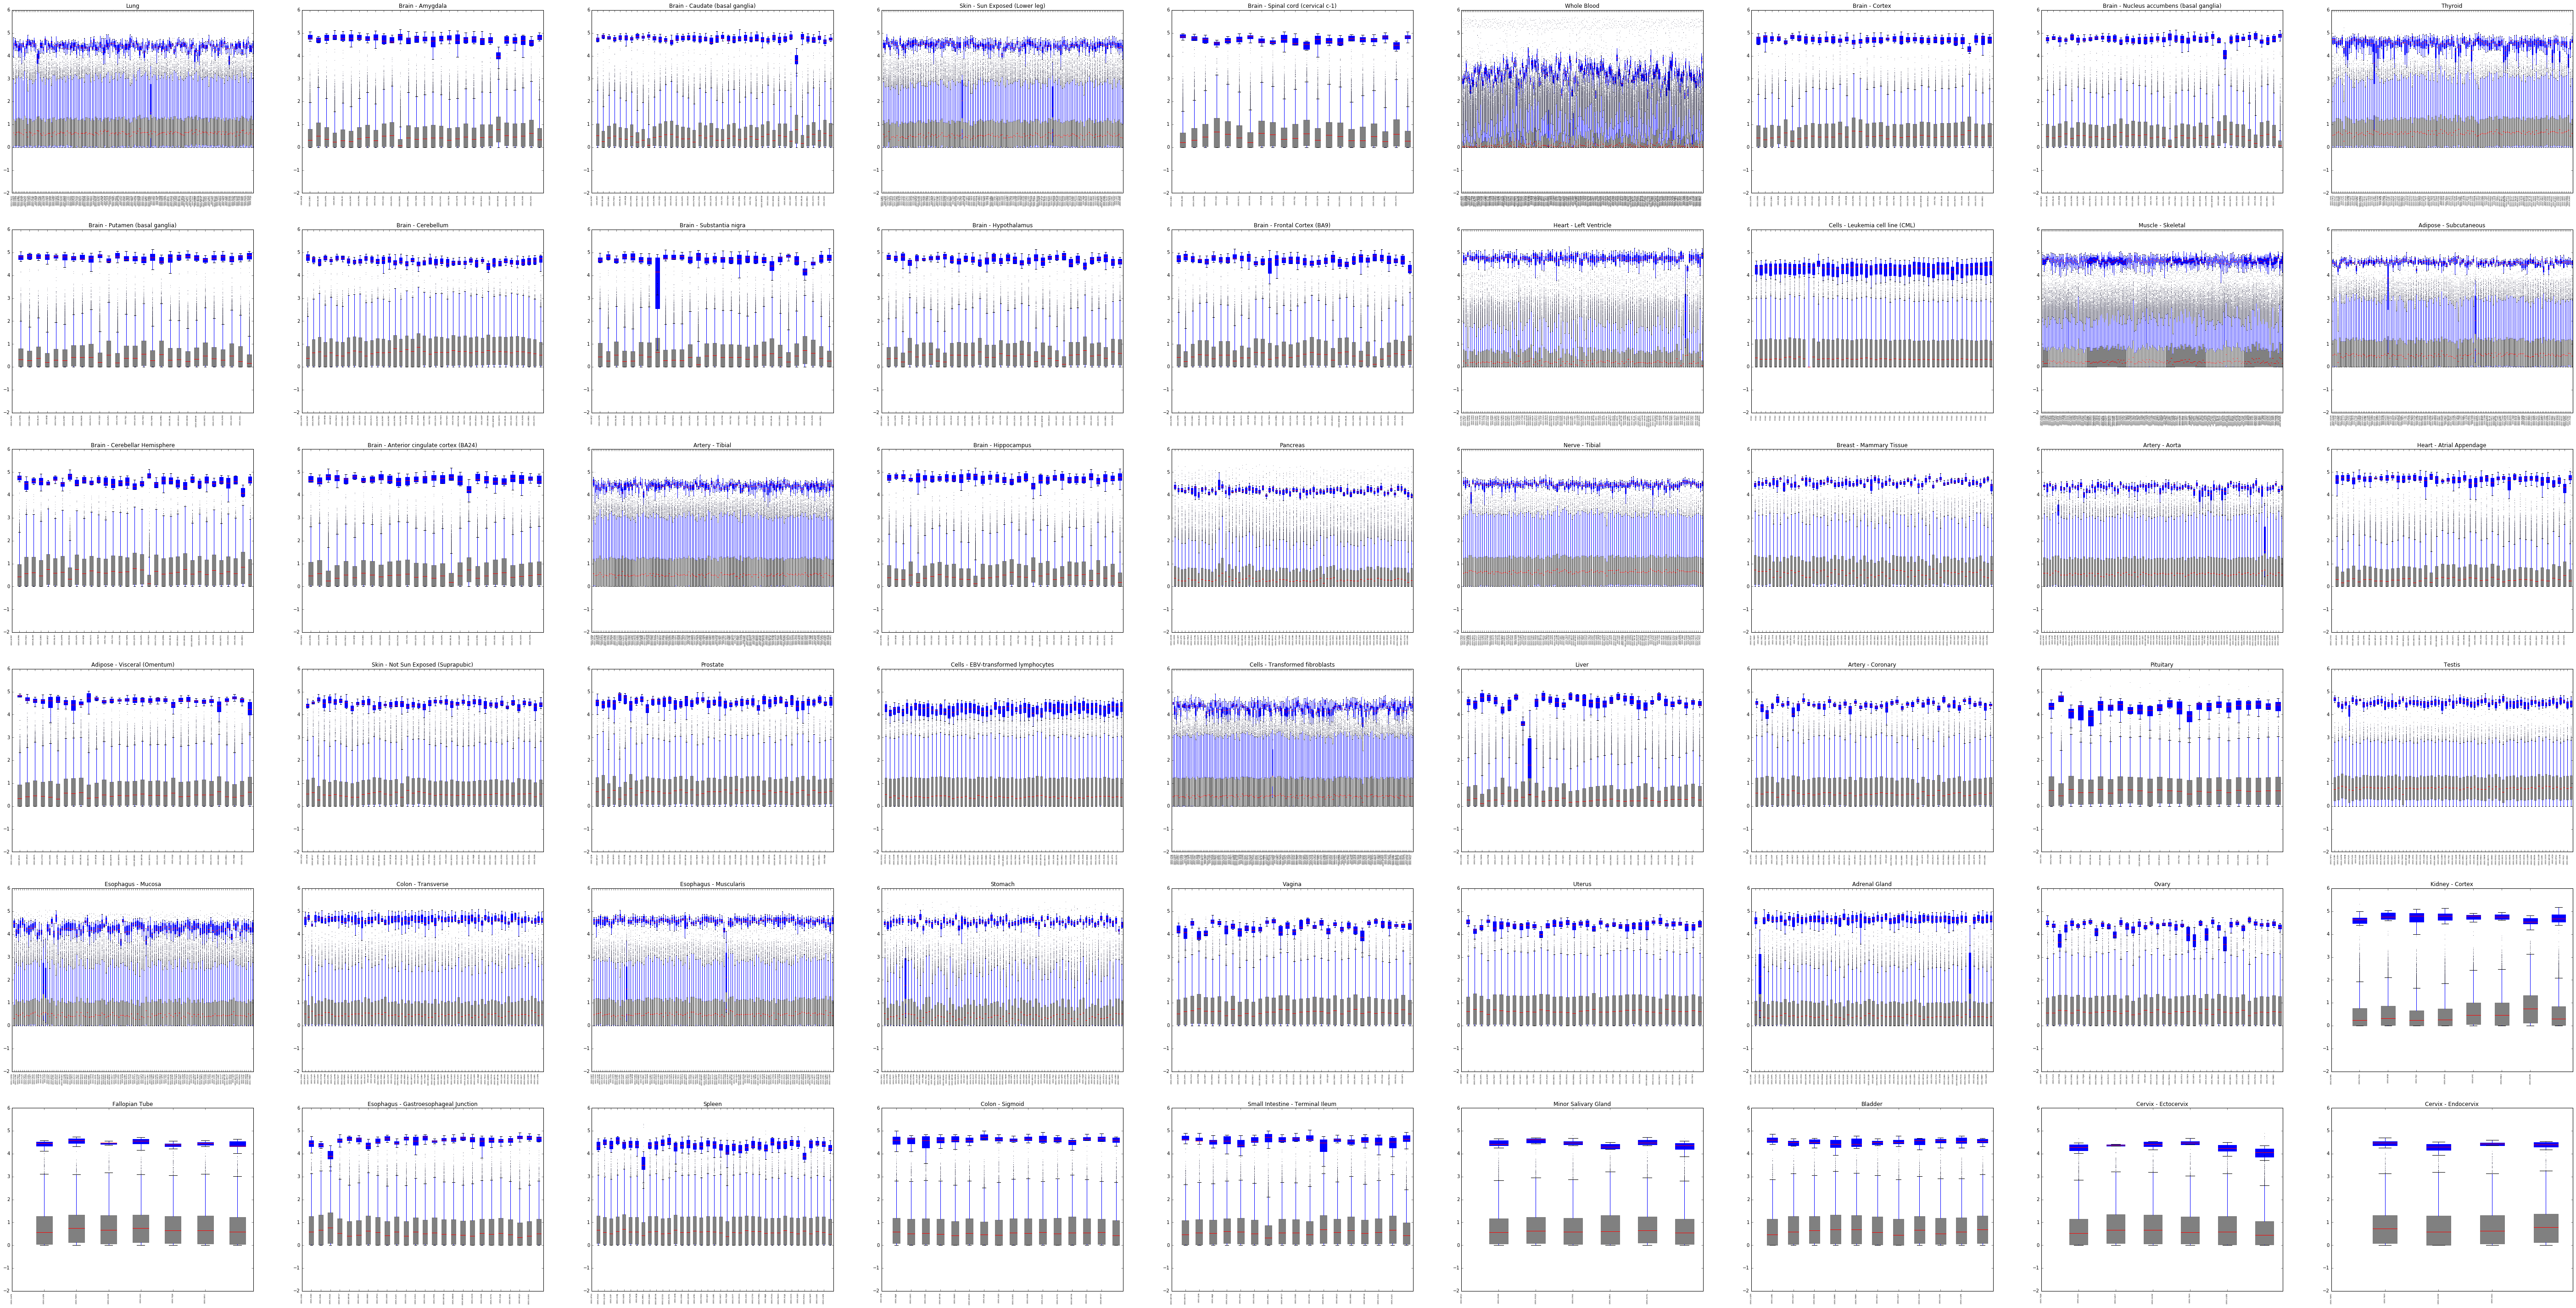

In [128]:
% matplotlib inline
plt.rcParams['figure.figsize'] = (100.0, 50.0)

n=0
for tissue in list(logNUC.tissue.drop_duplicates()):
    n+=1
    current_df = logNUC.loc[logNUC.tissue==tissue, list(logNUC.columns[2:])].transpose()
    current_mt = logMT.loc[logMT.tissue==tissue, list(logMT.columns[2:])].transpose()
    labels_tmp = list(current_df.columns)
    labels = list(logNUC.sid[labels_tmp])
    plt.subplot(6,9,n)
    plt.title(tissue)
    plt.ylim([-2,6])
    
    mt = current_mt.boxplot(grid=False, return_type='dict', patch_artist=True)
    nuc = current_df.boxplot(grid=False, return_type='dict', patch_artist=True)
    
    plt.setp(mt['boxes'], color='blue')
    plt.setp(mt['whiskers'], linestyle='-')
    plt.setp(mt['fliers'], marker='o', markersize=0.5,alpha=0.5)
    
    plt.setp(nuc['boxes'], color='grey')
    plt.setp(nuc['whiskers'], linestyle='-')
    plt.setp(nuc['fliers'], marker='o', markersize=0.5, alpha=0.5)
   
    
    plt.xticks(range(len(current_df.columns)), labels, rotation='vertical',fontsize=4)

In [124]:
mt.keys()

['boxes', 'fliers', 'medians', 'means', 'whiskers', 'caps']